In [68]:
import pandas as pd 
import numpy as np 
import plotly.express as px
import seaborn as sns 
import os 
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format',  '{:.4f}'.format)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_colwidth', 500)
pd.options.mode.chained_assignment = None

In [4]:
pwd = os.getcwd()
filepath = os.path.join(pwd,"bms_soc_data.parquet")
filepath

'c:\\Users\\ashis\\OneDrive\\Desktop\\Machine Learning\\bms_ml\\bms_soc_data.parquet'

## Data Loading and Exploration

In [5]:
df = pd.read_parquet(filepath)
df.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8
time,,,,,,,,,,,,,,
2023-11-07 12:20:00+00:00,100.0000,509.9220,3.4113,0.0262,-24.1460,24.1000,3.4018,3.4168,3.4110,3.4240,3.4138,3.3978,3.4136,3.4114
2023-11-07 12:20:10+00:00,100.0000,509.8500,3.4083,0.0252,-10.2840,24.1000,3.3998,3.4132,3.4082,3.4214,3.4104,3.3962,3.4096,3.4072
2023-11-07 12:20:20+00:00,100.0000,509.8200,3.4049,0.0246,-11.9420,24.1000,3.3968,3.4096,3.4042,3.4174,3.4068,3.3928,3.4066,3.4046
2023-11-07 12:20:30+00:00,100.0000,509.8100,3.4148,0.0256,17.6280,24.0800,3.4064,3.4202,3.4148,3.4292,3.4154,3.4036,3.4164,3.4124
2023-11-07 12:20:40+00:00,100.0000,510.0000,3.4208,0.0264,19.0480,24.1000,3.4112,3.4264,3.4200,3.4358,3.4220,3.4094,3.4224,3.4190


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200647 entries, 2023-11-07 12:20:00+00:00 to 2023-11-30 17:41:00+00:00
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   bms_state_of_charge       200646 non-null  float64
 1   bms_capacity_remaining    200646 non-null  float64
 2   bms_average_cell_voltage  200646 non-null  float64
 3   bms_delta_cell_voltage    200646 non-null  float64
 4   bms_current               200646 non-null  float64
 5   bms_temperature_2         200646 non-null  float64
 6   bms_cell_voltage_1        200646 non-null  float64
 7   bms_cell_voltage_2        200646 non-null  float64
 8   bms_cell_voltage_3        200646 non-null  float64
 9   bms_cell_voltage_4        200646 non-null  float64
 10  bms_cell_voltage_5        200646 non-null  float64
 11  bms_cell_voltage_6        200646 non-null  float64
 12  bms_cell_voltage_7        200646 non-null  float64
 13

### AIM:
- Attempt to calculate the SOC as accurate as we can 
- The internal current sensor is not accurate and has different error on charge and discharge 
- We need to detect voltage peaks and reset SOC to 100%
- It's the moment when we have average voltage at 3.43 and then drop below 3.37 (reset condition)

In [7]:
## Setting up the reset conditions for the SOC 

df2 = df.copy()

df2['reset_cond'] = df2['bms_average_cell_voltage'] > 3.43 # Assigns boolean if the value in "bms_average_cell_voltage" column is bigger than 3.43
df2['reset_cond_2'] = df2['bms_average_cell_voltage'].rolling(5).mean() < 3.37 # This calculates the rolling average of the "bms_average_cell_voltage" column for the past 5 rows(including the current row). Then it checks if the value is greater than 3.37 and assigns T or F acc.
df2['reset_cond'] = df2['reset_cond'].shift(100) & df2['reset_cond_2'] #  The .shift(100) function shifts the values in reset_cond by 100 positions upwards. This means the condition in reset_cond for a specific row will now depend on the voltage value 100 rows before it. The & (bitwise AND) combines the shifted reset_cond with the original reset_cond2. So, both conditions need to be True for the resulting reset_cond to be True in this step
df2['reset_cond_2'] = (df2['reset_cond'].shift(1)==1) & (df2['reset_cond']==0) # This line updates the reset_cond2 column. It checks if the previous row's reset_cond (shifted by 1 position) is True (equal to 1) and the current row's reset_cond is False (equal to 0). This likely identifies a transition from a high voltage state (True in reset_cond) to a low voltage state (False in reset_cond).
df2['cycle'] = df2['reset_cond_2'].cumsum().astype('int32') # This line creates a new column named cycle. It uses the .cumsum() function on reset_cond2 to count the cumulative number of times the condition in reset_cond2 (likely voltage state transitions) has occurred up to each row. The .astype('int32') converts the data type of this column to 32-bit integer. So, this column will now contain a label for each cycle.
df2['cycle_row'] = df2.groupby(['cycle']).cumcount() # This line creates a new column named cycle_row. It groups the DataFrame by the cycle labels and uses .cumcount() to assign a unique number (starting from 0) for each row within each cycle group. This provides an order within each cycle.

df2['reset_cond'] = df2['reset_cond'].astype('float16') * 10 # This line converts the data type of the reset_cond column to a more memory-efficient format (float16) and multiplies the values by 10. The reason for the multiplication by 10 is to scale the values according to the other values.



In summary, this code analyzes the bms_average_cell_voltage data to identify cycles based on voltage conditions. It likely looks for high voltage events followed by drops below a certain threshold. The labels in the cycle column and the row numbers in cycle_row can be used to further analyze these cycles.

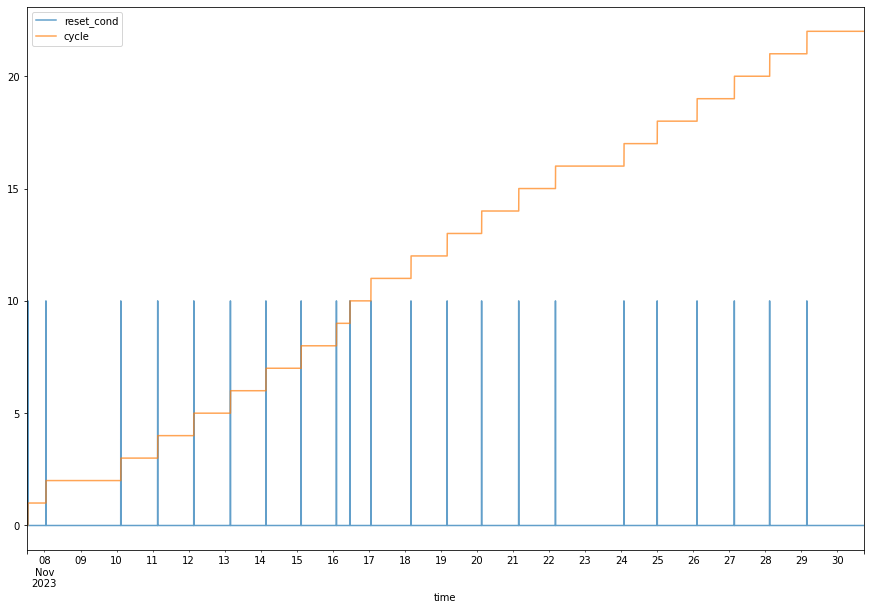

In [8]:
ax1 = df2.plot.line(y=['reset_cond', 'cycle'], alpha=0.7, figsize=(15,10))

In [9]:
# drop the non complete cycles

max_cycle = df2.cycle.max()
df2 = df2.loc[(df2.cycle > 0 ) & (df2.cycle < max_cycle)]

The previous code identified cycles in the data (likely based on voltage transitions). This filtering step might be interested in analyzing only complete cycles, excluding the initial and final ones. There could be reasons for this, such as:
 - The initial voltage readings might be unreliable or represent a charging phase.
- The final cycle might be incomplete due to the data collection duration.

In [10]:
# Error check per cycle (overshoot/undeshoot)
df2.groupby(['cycle'])['bms_current'].sum()/360 

cycle
1    25.7364
2    74.6367
3    40.1124
4    44.9095
5    43.2829
6    44.5532
7    42.3145
8    39.5854
9     9.3926
10   28.5061
11   45.7310
12   44.1852
13   43.2119
14   44.5188
15   45.2416
16   85.3169
17   37.2051
18   43.7802
19   44.3565
20   41.9262
21   44.9052
Name: bms_current, dtype: float64

In [11]:
# Difference between energy in and energy out for one cycle on average 
avg_shift_k = (df2.groupby(['cycle'])['bms_current'].sum()/360).mean()
avg_shift_k

43.495647023809525

In [12]:
# coloumbic efficiency of a lfp batetry is about 0.99 
coulombic_efficiency = 0.99


In [13]:
corr = df2.groupby(['cycle'])['bms_current'].agg([('discharge' , lambda x : x[x < 0].sum()) , ('charge' , lambda x : x[x > 0].sum())]) / 360
corr['k'] = -corr.charge * coulombic_efficiency / corr.discharge
corr.k.mean()

1.0872751906935172

In [14]:
corr

,discharge,charge,k
cycle,,,
1,-254.4879,280.2243,1.0901
2,-733.6864,808.3231,1.0907
3,-411.1234,451.2359,1.0866
4,-455.0306,499.9401,1.0877
5,-447.3130,490.5960,1.0858
6,-454.4383,498.9916,1.0871
7,-432.6954,475.0099,1.0868
8,-403.5639,443.1493,1.0871
9,-93.7963,103.1889,1.0891


In [15]:
discharge_sum = df2[df2.bms_current<0].bms_current.sum()
charge_sum = df2[df2.bms_current>0].bms_current.sum()
corr_k = charge_sum * coulombic_efficiency/ - discharge_sum
corr_k

1.0870208977500797

In [20]:
def correct(x):
    if x < 0:
        return x * corr_k
    return x

df2.loc[:, 'bms_current_corrected'] = df2['bms_current'].apply(correct).copy()

In [23]:
# Calculated SOC

max_capacity = 510
df2.loc[:, 'calculated_soc'] = (((df2.groupby(['cycle'])['bms_current_corrected'].cumsum()/360)+ max_capacity)/max_capacity) *100.0
df2.loc[:, 'calculated_soc'] = df2.calculated_soc.clip(0, 100.0)

**SOC Calculation:**

- .loc[:, 'calculated_soc'] = ... assigns a new column named "calculated_soc" to df2. This column will store the calculated state of charge for each data point.
- The value assigned involves multiple steps:
     - **GroupBy and Cumulative Sum:**
         - df2.groupby(['cycle'])['bms_current_corrected'].cumsum() calculates the cumulative sum of a column named "bms_current_corrected" for each group defined by the "cycle" column. This likely represents the total corrected current that has flowed into or out of the battery for each charging/discharging cycle.
     - Division and Normalization:
         - The cumulative sum is divided by 360. This value (360) might represent a conversion factor or time interval (e.g., 360 seconds per cycle).
         - The result is then divided by max_capacity to normalize the value between 0 and 1.

     -**Percentage Conversion:**
         - The normalized value is multiplied by 100.0 to convert it into a percentage representing the calculated state of charge.
     -**Limiting SOC Values:**
          - .clip(0, 100.0) ensures the "calculated_soc" values are within the valid range of 0% (completely discharged) to 100% (fully charged). Any values below 0 are set to 0, and any values above 100 are set to 100.

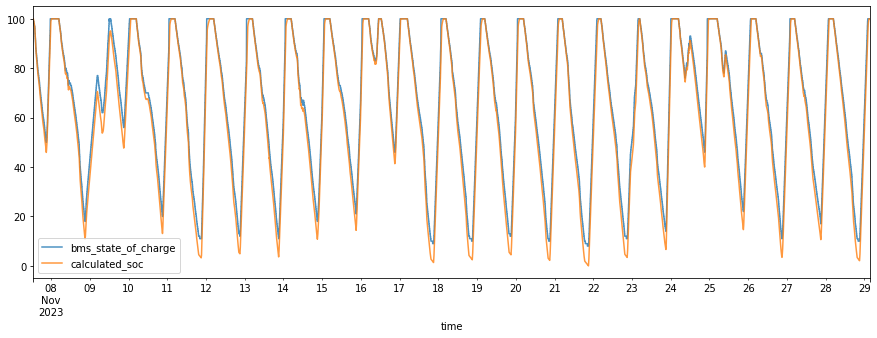

In [29]:
ax1 = df2.plot.line( y=['bms_state_of_charge', 'calculated_soc'], alpha = 0.8, figsize = (15,5))


In [32]:
df2 = df2.drop(columns=['reset_cond', 'reset_cond_2'])

In [34]:
# Let's explore the cell voltage column in depth 

df2['cd'] = (df2.bms_average_cell_voltage - df2.bms_cell_voltage_4)

df2['cd2'] = abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_1) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_2) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_3) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_4) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_5) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_6) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_7) + \
            abs(df2.bms_average_cell_voltage - df2.bms_cell_voltage_8) 
df2['cd3'] = (df2.bms_average_cell_voltage - df2.bms_cell_voltage_7)

In [35]:
def cord(r):
    cl = [ r['bms_cell_voltage_1'], r['bms_cell_voltage_2'], r['bms_cell_voltage_3'], \
          r['bms_cell_voltage_4'], r['bms_cell_voltage_5'], r['bms_cell_voltage_6'], \
          r['bms_cell_voltage_7'], r['bms_cell_voltage_8'],]
    sorted_cl = [i[0] for i in sorted(enumerate(cl), key=lambda x:x[1])]
    return int(''.join(str(item) for item in sorted_cl))

df2['cord'] = df2.apply(cord, axis=1)
df2.head(10)

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,cycle_row,bms_current_corrected,calculated_soc,cd,cd2,cd3,cord
time,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,1,0,-11.9094,99.9935,0.0010,0.0103,0.0004,53160472
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,1,1,-12.2659,99.9868,0.0007,0.0100,0.0001,51306742
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,1,2,-10.0267,99.9814,0.0008,0.0098,0.0002,51367042
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,1,3,-11.0072,99.9754,0.0002,0.0086,0.0006,51630742
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,1,4,-6.8374,99.9717,0.0013,0.0092,-0.0001,53160472
2023-11-07 12:59:00+00:00,99.0000,507.0920,3.3254,0.0060,-15.5680,23.9600,3.3248,3.3246,3.3282,3.3242,3.3266,3.3226,3.3256,3.3268,1,5,-16.9227,99.9624,0.0012,0.0110,-0.0002,53106472
2023-11-07 12:59:10+00:00,99.0000,507.0680,3.3270,0.0044,-7.9860,23.9400,3.3264,3.3260,3.3284,3.3266,3.3282,3.3246,3.3270,3.3284,1,6,-8.6809,99.9577,0.0004,0.0084,-0.0000,51036427
2023-11-07 12:59:20+00:00,99.0000,507.0420,3.3230,0.0060,-15.3240,23.9400,3.3228,3.3228,3.3248,3.3218,3.3246,3.3202,3.3228,3.3244,1,7,-16.6575,99.9486,0.0012,0.0094,0.0002,53016742
2023-11-07 12:59:30+00:00,99.0000,507.0120,3.3260,0.0052,-16.6020,23.9800,3.3262,3.3256,3.3282,3.3250,3.3272,3.3234,3.3260,3.3266,1,8,-18.0467,99.9388,0.0010,0.0082,0.0000,53160742


This code defines a function named cord that likely processes cell voltages in a battery pack and returns an integer value. Here's a breakdown:

1. Function Definition:
     - def cord(r): defines a function named cord that takes a single argument named r. This argument likely represents a row from a pandas dataframe containing battery data.

2. Cell Voltage List:

     - cl = [ ... ] creates a list named cl.
     - It extracts the voltage values for all eight cells (from cell 1 to cell 8) from the r argument using dictionary access with keys like 'bms_cell_voltage_1', 'bms_cell_voltage_2', etc.

3. Voltage Sorting with Index:

     - sorted(enumerate(cl), key=lambda x:x[1]) sorts the cl list based on the voltage values (the second element in each tuple returned by enumerate).
     - enumerate(cl) creates an iterable where each element is a tuple containing the index (position) and the corresponding voltage value from the cl list.
     - key=lambda x:x[1] specifies that the sorting should happen based on the second element (voltage value) of each tuple.
     - The result is a list of sorted tuples where the first element is the original index and the second element is the sorted voltage value.

4. Extracting Sorted Indexes:
     - [i[0] for i in sorted_cl] iterates through the sorted list (sorted_cl) and extracts only the first element (original index) from each tuple. This effectively creates a list containing the sorted order of the cell indexes based on their voltages.

5. Joining Indexes as String:
      - ''.join(str(item) for item in sorted_cl) joins all the elements (sorted cell indexes) in the list obtained in step 4 into a single string. The str() function ensures each element is converted to a string before joining.

6. Returning Integer:
     - return int(''.join( ... )) converts the joined string (representing the sorted cell indexes) into an integer. This essentially creates a unique integer code based on the order of cell voltages.

**In summary, the cord function takes a row of battery data, sorts the cell voltages, and returns an integer that represents the order of those voltages. This code could be used for tasks like identifying specific voltage patterns or tracking changes in the order of cell voltages within a battery pack.**

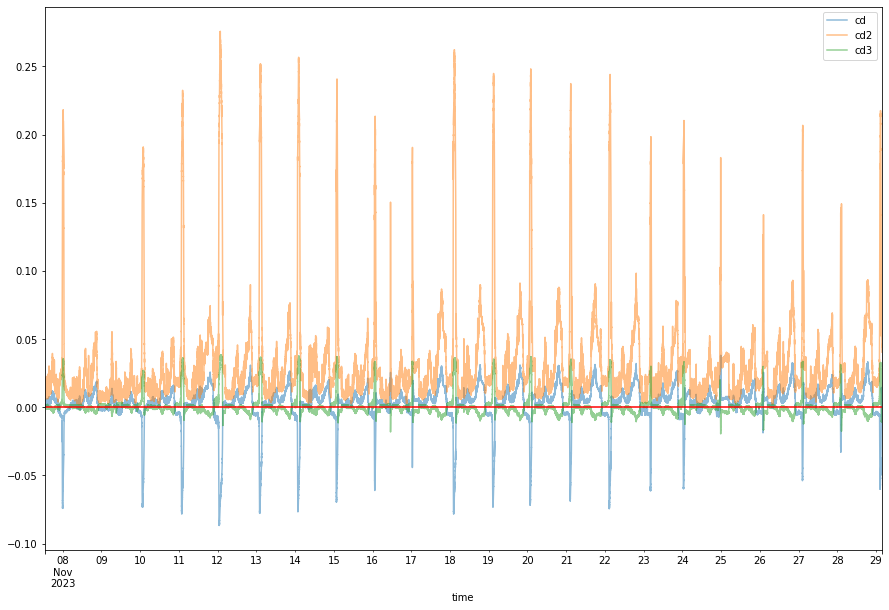

In [36]:
# Let's plot cd, cd2 and cd3 to visualise it better 

ax1 = df2.plot.line( y = ['cd', 'cd2', 'cd3'], alpha = 0.5, figsize = (15, 10))
ax1.axhline(0, c='r')

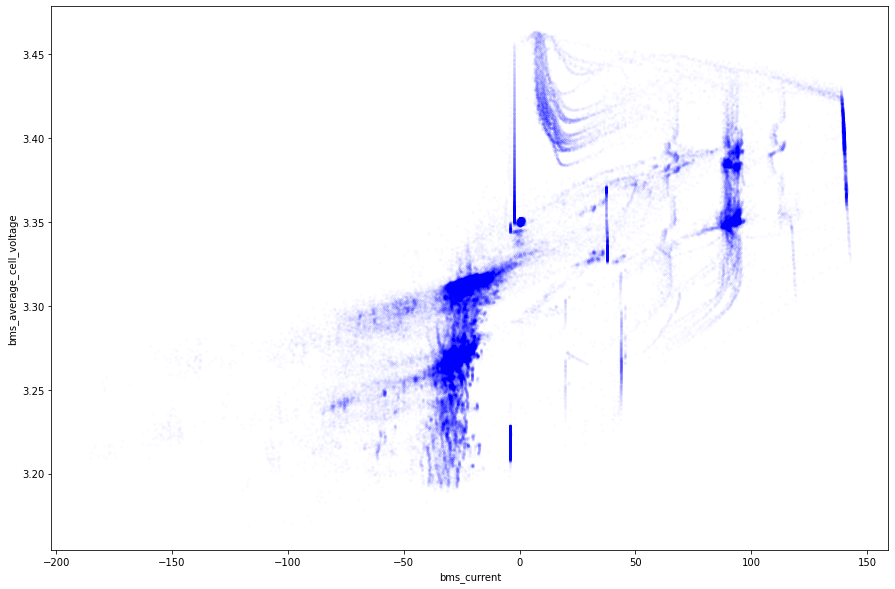

In [37]:
# Relationship between current and battery cell voltages 

ax1 = df2.plot.scatter( x = 'bms_current', y ='bms_average_cell_voltage', c = 'blue', alpha = 0.01, marker = '.', figsize = (15, 10))

In [43]:
df3 = df2.copy()
df3['volt_diff'] = df2.bms_average_cell_voltage.diff()
df3['current_diff'] = df2.bms_current.diff()

In [44]:
df3

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,cycle_row,bms_current_corrected,calculated_soc,cd,cd2,cd3,cord,volt_diff,current_diff
time,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,1,0,-11.9094,99.9935,0.0010,0.0103,0.0004,53160472,NaN,NaN
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,1,1,-12.2659,99.9868,0.0007,0.0100,0.0001,51306742,-0.0005,-0.3280
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,1,2,-10.0267,99.9814,0.0008,0.0098,0.0002,51367042,-0.0003,2.0600
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,1,3,-11.0072,99.9754,0.0002,0.0086,0.0006,51630742,0.0007,-0.9020
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,1,4,-6.8374,99.9717,0.0013,0.0092,-0.0001,53160472,-0.0017,3.8360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-29 03:40:10+00:00,100.0000,509.3020,3.3568,0.0160,-2.4100,26.4600,3.3550,3.3534,3.3640,3.3490,3.3610,3.3480,3.3620,3.3620,21,8917,-2.6197,100.0000,0.0078,0.0436,-0.0052,53104672,-0.0003,-0.0800
2023-11-29 03:40:20+00:00,100.0000,509.2960,3.3567,0.0160,-2.3700,26.5000,3.3550,3.3530,3.3640,3.3490,3.3610,3.3480,3.3616,3.3620,21,8918,-2.5762,100.0000,0.0077,0.0436,-0.0049,53104672,-0.0001,0.0400
2023-11-29 03:40:30+00:00,100.0000,509.2900,3.3564,0.0160,-2.4500,26.4400,3.3550,3.3530,3.3640,3.3490,3.3610,3.3480,3.3600,3.3608,21,8919,-2.6632,100.0000,0.0074,0.0408,-0.0036,53106742,-0.0004,-0.0800


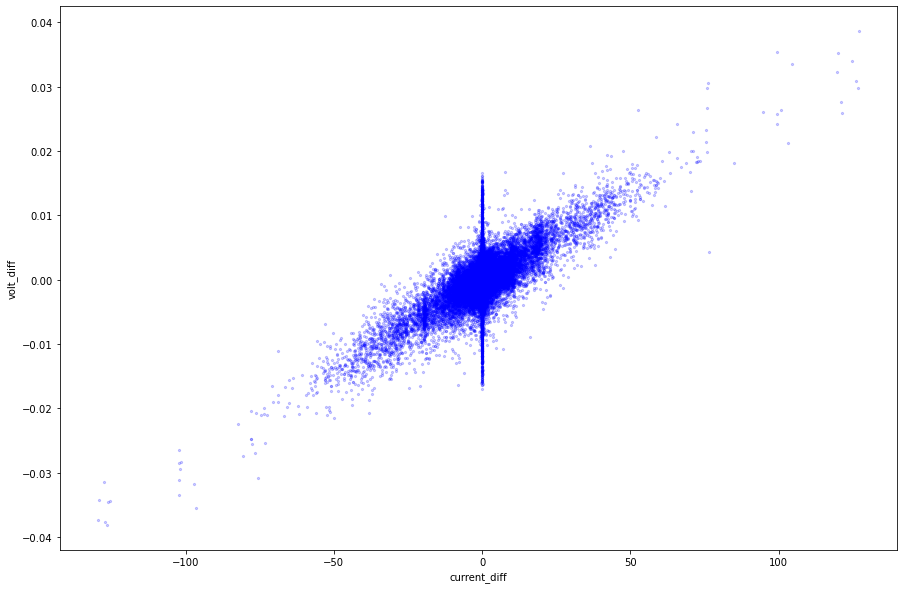

In [45]:
ax1 = df3.plot.scatter(x='current_diff', y = 'volt_diff', c = 'blue', alpha=0.2, marker = '.', figsize = (15,10))

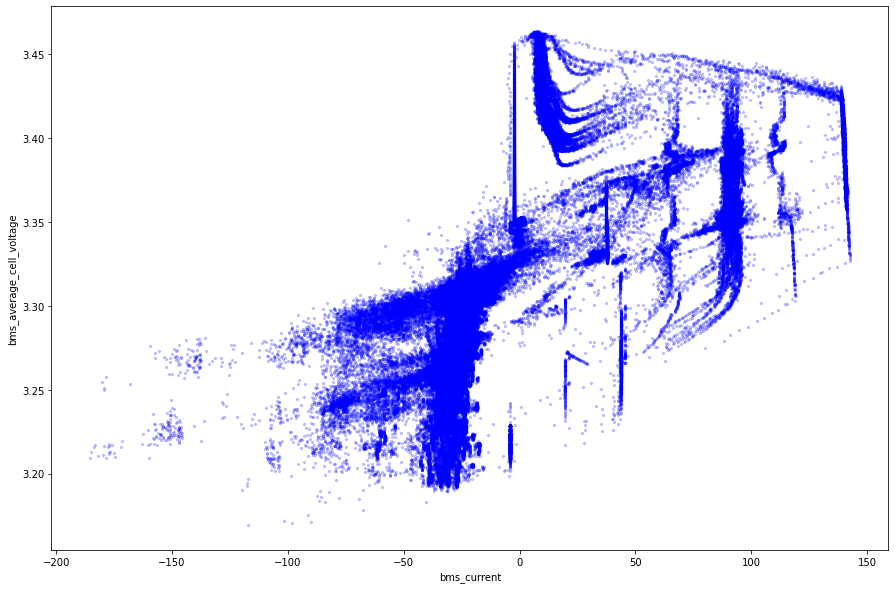

In [50]:
ax1 = df3.plot.scatter(x='bms_current', y = 'bms_average_cell_voltage', c = 'blue', alpha=0.2, marker = '.', figsize = (15,10))

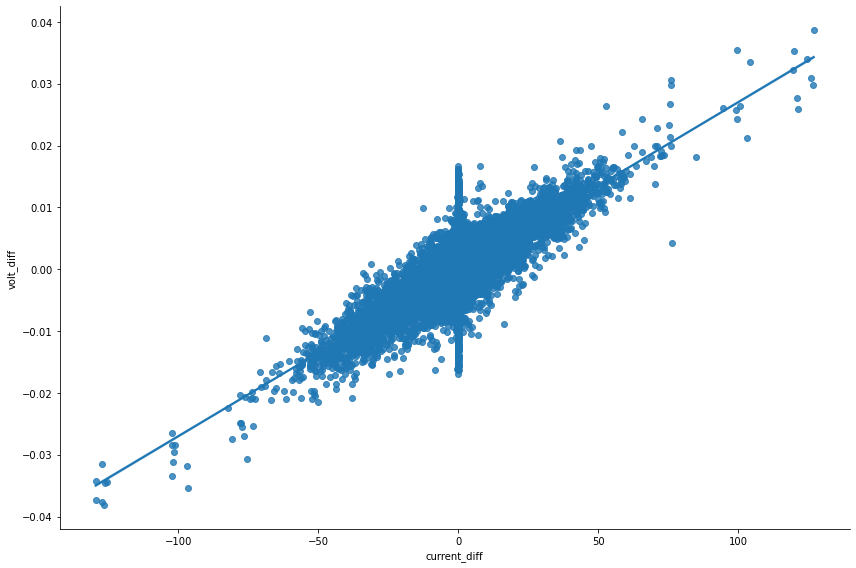

In [51]:
sns.lmplot(x='current_diff', y = 'volt_diff',data = df3, fit_reg=True, height=8, aspect=1.5)

In [52]:
from sklearn.linear_model import LinearRegression
df3  = df3.dropna()
X = df3.current_diff.values.reshape(-1,1)
y = df3.volt_diff.values.reshape(-1,1)

In [54]:
lin_reg = LinearRegression()
reg = lin_reg.fit(X,y)
reg.score(X,y)

0.4627582050076303

In [56]:
reg.coef_[0][0]

0.0002699411538382038

In [57]:
reg.intercept_[0]

1.330512839575318e-07

### Modeling 

In [58]:
df2.head()

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,cycle_row,bms_current_corrected,calculated_soc,cd,cd2,cd3,cord
time,,,,,,,,,,,,,,,,,,,,,,
2023-11-07 12:58:10+00:00,99.0000,507.2280,3.3280,0.0060,-10.9560,23.9600,3.3278,3.3276,3.3306,3.3270,3.3292,3.3246,3.3276,3.3292,1,0,-11.9094,99.9935,0.0010,0.0103,0.0004,53160472
2023-11-07 12:58:20+00:00,99.0000,507.2000,3.3275,0.0058,-11.2840,23.9400,3.3270,3.3264,3.3304,3.3268,3.3288,3.3248,3.3274,3.3282,1,1,-12.2659,99.9868,0.0007,0.0100,0.0001,51306742
2023-11-07 12:58:30+00:00,99.0000,507.1700,3.3272,0.0058,-9.2240,24.0000,3.3276,3.3262,3.3298,3.3264,3.3288,3.3242,3.3270,3.3274,1,2,-10.0267,99.9814,0.0008,0.0098,0.0002,51367042
2023-11-07 12:58:40+00:00,99.0000,507.1400,3.3278,0.0054,-10.1260,23.9400,3.3278,3.3272,3.3302,3.3276,3.3290,3.3250,3.3272,3.3286,1,3,-11.0072,99.9754,0.0002,0.0086,0.0006,51630742
2023-11-07 12:58:50+00:00,99.0000,507.1140,3.3261,0.0050,-6.2900,23.9200,3.3264,3.3254,3.3276,3.3248,3.3272,3.3234,3.3262,3.3276,1,4,-6.8374,99.9717,0.0013,0.0092,-0.0001,53160472


In [59]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
bms_state_of_charge,186736.0000,65.5171,27.6299,8.0000,44.0000,69.0000,90.0000,100.0000
bms_capacity_remaining,186736.0000,334.0642,140.8065,40.5120,224.0145,353.5540,460.1261,510.0000
bms_average_cell_voltage,186736.0000,3.3120,0.0541,3.1693,3.2701,3.3121,3.3499,3.4636
bms_delta_cell_voltage,186736.0000,0.0148,0.0170,0.0012,0.0060,0.0096,0.0160,0.1116
bms_current,186736.0000,1.7609,49.9652,-185.6200,-27.8200,-20.6400,10.7640,142.8620
bms_temperature_2,186736.0000,24.2248,2.4746,19.4800,22.4800,23.8000,25.5800,33.4000
bms_cell_voltage_1,186736.0000,3.3133,0.0531,3.1758,3.2716,3.3134,3.3490,3.4794
bms_cell_voltage_2,186736.0000,3.3114,0.0600,3.1552,3.2690,3.3118,3.3480,3.4768
bms_cell_voltage_3,186736.0000,3.3131,0.0515,3.1770,3.2716,3.3136,3.3530,3.4788
bms_cell_voltage_4,186736.0000,3.3096,0.0647,3.1384,3.2656,3.3094,3.3466,3.4906


In [60]:
df2.isna().sum()

bms_state_of_charge         1
bms_capacity_remaining      1
bms_average_cell_voltage    1
bms_delta_cell_voltage      1
bms_current                 1
bms_temperature_2           1
bms_cell_voltage_1          1
bms_cell_voltage_2          1
bms_cell_voltage_3          1
bms_cell_voltage_4          1
bms_cell_voltage_5          1
bms_cell_voltage_6          1
bms_cell_voltage_7          1
bms_cell_voltage_8          1
cycle                       0
cycle_row                   0
bms_current_corrected       1
calculated_soc              1
cd                          1
cd2                         1
cd3                         1
cord                        0
dtype: int64

In [61]:
# Adding a delay in the dataset of 90 seconds 

df2['soc_d'] = df2.calculated_soc.shift(90)
df2['curr_d'] = df2.bms_current.shift(90)
df2['volt_d'] = df2.bms_average_cell_voltage.shift(90)

In [62]:
df2['v_c'] = df2.bms_average_cell_voltage - df2.bms_current * 0.001

In [64]:
df2['volt_diff'] = df2.bms_average_cell_voltage.diff()

In [65]:
df2['roll_v_10'] = df2.bms_average_cell_voltage.rolling(10).mean()
df2['roll_c_10'] = df2.bms_current.rolling(10).mean()

df2['roll_cs_90'] = df2.bms_current.rolling(90).sum()


df2['roll_v_90'] = df2.bms_average_cell_voltage.rolling(90).mean()
df2['roll_c_90'] = df2.bms_current.rolling(90).mean()

df2['temp_roll_90'] = df2.bms_temperature_2.rolling(90).mean()

In [66]:
df2['roll_d_10'] = df2.volt_diff.rolling(10).mean()
df2['roll_d_25'] = df2.volt_diff.rolling(25).mean()
df2['d_trend'] = df2.roll_d_10 / (df2.roll_d_25 + 1 )

In [78]:
df2 = df2.dropna()

In [79]:
cycle_row_max = 24*60*60/10
df2 = df2.loc[df2.cycle_row>cycle_row_max]

In [80]:
df2.head(10)

,bms_state_of_charge,bms_capacity_remaining,bms_average_cell_voltage,bms_delta_cell_voltage,bms_current,bms_temperature_2,bms_cell_voltage_1,bms_cell_voltage_2,bms_cell_voltage_3,bms_cell_voltage_4,bms_cell_voltage_5,bms_cell_voltage_6,bms_cell_voltage_7,bms_cell_voltage_8,cycle,...,cord,soc_d,curr_d,volt_d,v_c,volt_diff,roll_v_10,roll_c_10,roll_cs_90,roll_v_90,roll_c_90,temp_roll_90,roll_d_10,roll_d_25,d_trend
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-11-09 01:00:00+00:00,51.0000,257.6900,3.3345,0.0042,37.7440,24.4400,3.3342,3.3342,3.3346,3.3364,3.3342,3.3360,3.3332,3.3330,2,...,76014253,41.7247,37.8320,3.3316,3.2967,0.0000,3.3338,37.8452,3406.1620,3.3333,37.8462,24.3898,0.0003,0.0001,0.0003
2023-11-09 01:00:10+00:00,51.0000,257.7960,3.3336,0.0044,37.8760,24.4800,3.3332,3.3336,3.3346,3.3354,3.3332,3.3348,3.3318,3.3322,2,...,67041253,41.7453,37.8760,3.3331,3.2957,-0.0009,3.3337,37.8408,3406.1620,3.3333,37.8462,24.3911,-0.0001,-0.0000,-0.0001
2023-11-09 01:00:20+00:00,51.0000,257.9000,3.3332,0.0036,37.8320,24.4600,3.3336,3.3332,3.3340,3.3346,3.3326,3.3340,3.3314,3.3322,2,...,67410253,41.7659,37.8320,3.3323,3.2954,-0.0004,3.3338,37.8408,3406.1620,3.3333,37.8462,24.3927,0.0001,-0.0000,0.0001
2023-11-09 01:00:30+00:00,51.0000,258.0060,3.3334,0.0042,37.7880,24.4400,3.3328,3.3336,3.3340,3.3350,3.3324,3.3350,3.3324,3.3320,2,...,74601235,41.7865,37.8320,3.3336,3.2956,0.0002,3.3336,37.8276,3406.1180,3.3333,37.8458,24.3940,-0.0001,0.0001,-0.0001
2023-11-09 01:00:40+00:00,51.0000,258.1100,3.3332,0.0036,37.8760,24.4600,3.3328,3.3330,3.3340,3.3348,3.3326,3.3342,3.3318,3.3320,2,...,67401253,41.8071,37.7880,3.3327,3.2953,-0.0002,3.3337,37.8276,3406.2060,3.3333,37.8467,24.3956,0.0001,-0.0000,0.0001
2023-11-09 01:00:50+00:00,51.0000,258.2160,3.3333,0.0044,37.8320,24.4400,3.3332,3.3332,3.3342,3.3350,3.3328,3.3346,3.3314,3.3318,2,...,67401253,41.8277,37.7440,3.3341,3.2954,0.0001,3.3337,37.8188,3406.2940,3.3333,37.8477,24.3967,0.0000,-0.0000,0.0000
2023-11-09 01:01:00+00:00,51.0000,258.3200,3.3340,0.0038,37.8780,24.4400,3.3342,3.3338,3.3352,3.3354,3.3338,3.3350,3.3326,3.3322,2,...,76140523,41.8483,37.7880,3.3320,3.2961,0.0008,3.3336,37.8234,3406.3840,3.3333,37.8487,24.3978,-0.0001,0.0000,-0.0001
2023-11-09 01:01:10+00:00,51.0000,258.4260,3.3338,0.0044,37.9200,24.4400,3.3334,3.3336,3.3344,3.3356,3.3330,3.3354,3.3324,3.3324,2,...,67401253,41.8688,37.7440,3.3337,3.2958,-0.0003,3.3337,37.8322,3406.5600,3.3333,37.8507,24.3991,0.0001,0.0000,0.0001
2023-11-09 01:01:20+00:00,51.0000,258.5300,3.3328,0.0038,37.8320,24.5000,3.3326,3.3328,3.3338,3.3342,3.3322,3.3338,3.3310,3.3316,2,...,67401253,41.8894,37.7440,3.3314,3.2949,-0.0010,3.3336,37.8410,3406.6480,3.3333,37.8516,24.4007,-0.0001,-0.0000,-0.0001


In [82]:
corr_df = df2.corr()

In [86]:
corr_df['calculated_soc'].sort_values(ascending = False)

calculated_soc              1.0000
soc_d                       0.9949
bms_capacity_remaining      0.9938
bms_state_of_charge         0.9937
v_c                         0.8085
temp_roll_90                0.7886
volt_d                      0.7880
bms_temperature_2           0.7716
roll_v_90                   0.7683
bms_cell_voltage_2          0.7404
roll_v_10                   0.7344
bms_cell_voltage_4          0.7338
bms_cell_voltage_8          0.7311
bms_average_cell_voltage    0.7303
bms_cell_voltage_1          0.7282
bms_cell_voltage_5          0.7237
bms_cell_voltage_3          0.7201
bms_cell_voltage_7          0.7132
bms_cell_voltage_6          0.6969
cd3                         0.4582
cord                        0.4074
cd2                         0.3505
bms_delta_cell_voltage      0.3375
curr_d                      0.1972
roll_cs_90                  0.1423
roll_c_90                   0.1423
bms_current_corrected       0.0906
roll_c_10                   0.0896
bms_current         

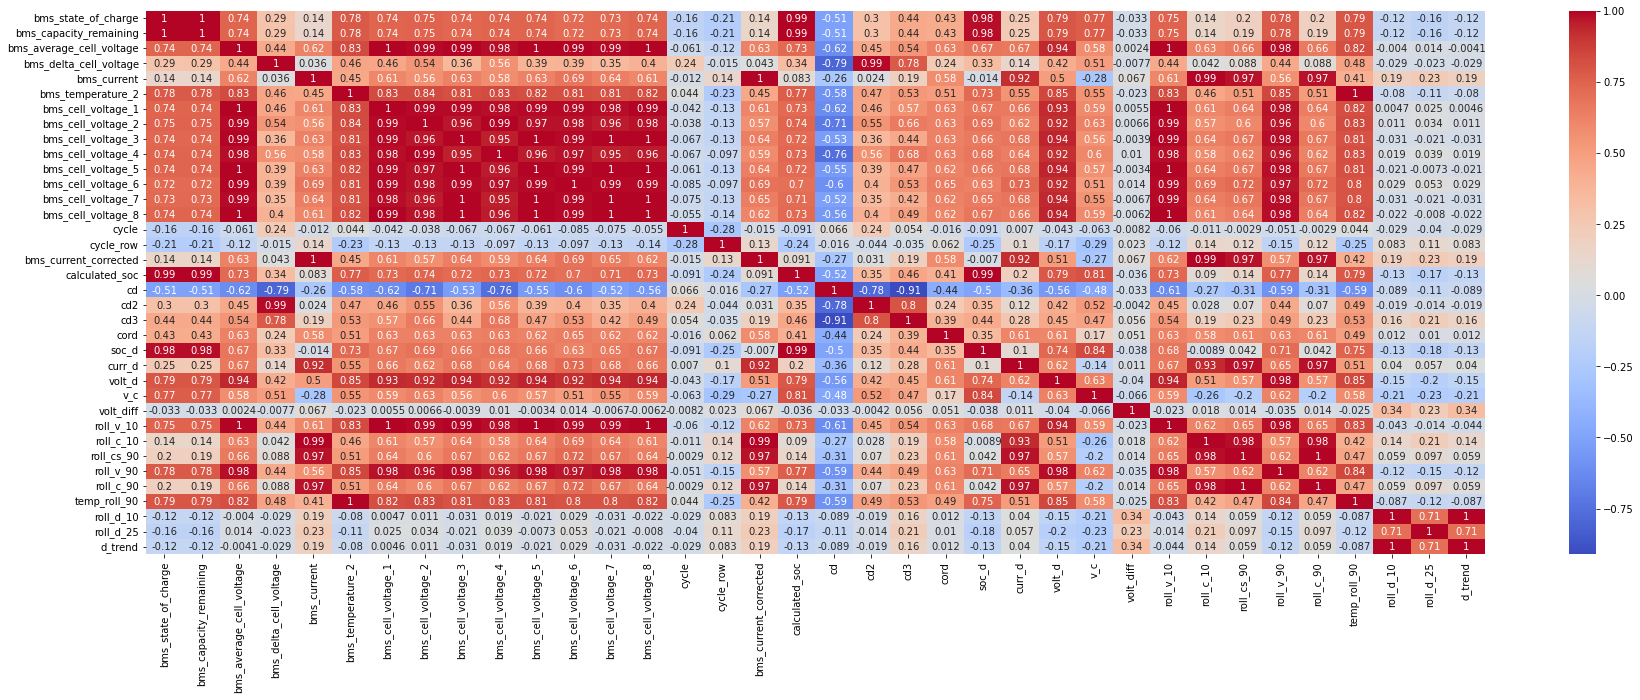

In [87]:
plt.figure(figsize=(30, 10))
sns.heatmap(data=corr_df, annot=True, cmap='coolwarm')
plt.show()

In [91]:
X = df2[['bms_current','bms_average_cell_voltage','soc_d','roll_c_10', 
         'roll_c_90', 
         'roll_v_10', 
         'roll_v_90', 
         'roll_cs_90',
         'bms_temperature_2',
         'temp_roll_90'
]]

#y = df2['bms_state_of_charge'] 
y = df2['calculated_soc']

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [96]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.30, random_state=42)

In [97]:
train_X.shape

(14238, 10)

### Linear Regression 

In [99]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)

LinearRegression()

In [100]:
# Compare against some Test Data 

original_values = test_y[:5]

predicted_values = lin_reg.predict(test_X[:5])

comparison_dataframe = pd.DataFrame(data = {"Original Values": original_values, "Predicted Values": predicted_values})
comparison_dataframe["Differences"] = comparison_dataframe["Original Values"] - comparison_dataframe["Predicted Values"]
comparison_dataframe["Error"] = (comparison_dataframe["Original Values"] - comparison_dataframe["Predicted Values"])/ comparison_dataframe["Original Values"] * 100

comparison_dataframe

,Original Values,Predicted Values,Differences,Error
time,,,,
2023-11-09 22:41:50+00:00,67.1929,67.1686,0.0243,0.0362
2023-11-18 02:25:10+00:00,98.2532,98.1064,0.1467,0.1494
2023-11-09 08:56:30+00:00,58.8978,58.7992,0.0986,0.1675
2023-11-10 00:33:40+00:00,91.3061,91.2804,0.0257,0.0281
2023-11-09 06:57:30+00:00,58.7711,58.7746,-0.0035,-0.0060


In [101]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(original_values, predicted_values)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0806571193839678

### Decision Tree Regressor

In [103]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_X, train_y)

DecisionTreeRegressor(random_state=42)

In [104]:
tree_pred = tree_reg.predict(test_X)
tree_mse = mean_squared_error(test_y, tree_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.1078758613818376

In [105]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, train_X, train_y, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [106]:
def display_scores(scores):

    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())


display_scores(tree_rmse_scores)

Scores: [0.07147461 0.08819221 0.10663399 0.07318419 0.09306248 0.07406288
 0.09848763 0.08429506 0.08147099 0.07448663]
Mean: 0.08453506709540418
Standard Deviation: 0.01135178254349662


### Random Forest Regressor 

In [107]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_X, train_y)

RandomForestRegressor(random_state=42)

In [108]:
train_pred = forest_reg.predict(train_X)
forest_mse = mean_squared_error(train_y, train_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.017569259978202783

In [109]:
from sklearn.model_selection import GridSearchCV

param_grid = [
     # try 12 [3x4] combinations of hyperparameters
    { 'n_estimators':[3,10,30], 'max_features':[2,4,6,8]

    },
    # Then try 6 (2x3) combinations with bootstrap set as False
    {
        'bootstrap': [False], 'n_estimators': [3,10], 'max_features':[2,3,4]
    }
]

forest_reg = RandomForestRegressor(random_state=42)

#train across 5 folds, thats a total of (12+6)x5 = 90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [110]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [111]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

In [112]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

0.6207805800367234 {'max_features': 2, 'n_estimators': 3}
0.3162076604415946 {'max_features': 2, 'n_estimators': 10}
0.2089190046733424 {'max_features': 2, 'n_estimators': 30}
0.2244525236576028 {'max_features': 4, 'n_estimators': 3}
0.143024550988939 {'max_features': 4, 'n_estimators': 10}
0.08588334334102878 {'max_features': 4, 'n_estimators': 30}
0.15518260351180085 {'max_features': 6, 'n_estimators': 3}
0.08701535800010049 {'max_features': 6, 'n_estimators': 10}
0.058520407730543005 {'max_features': 6, 'n_estimators': 30}
0.09978199966085093 {'max_features': 8, 'n_estimators': 3}
0.06734746422927267 {'max_features': 8, 'n_estimators': 10}
0.05346612895087616 {'max_features': 8, 'n_estimators': 30}
0.4616593244344169 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.26693720910205054 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.3072538485619876 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.1570283885462637 {'bootstrap': False, 'max_features

#### Randomized search 

In [114]:
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

param_dist = { 
    'n_estimators': randint(low= 1,high = 100),
    'max_features': randint(low= 1,high = 8)
}

fores_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(train_X, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E2076C24D0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E2076C1390>},
                   random_state=42, scoring='neg_mean_squared_error')

In [115]:
cv_res = rnd_search.cv_results_

for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(np.sqrt(-mean_score), params)

0.05143131175805821 {'max_features': 7, 'n_estimators': 52}
0.10593913903030885 {'max_features': 5, 'n_estimators': 15}
0.10412944963946863 {'max_features': 3, 'n_estimators': 72}
0.0989808754192289 {'max_features': 5, 'n_estimators': 21}
0.04594987807728787 {'max_features': 7, 'n_estimators': 83}
0.04718900149112957 {'max_features': 7, 'n_estimators': 75}
0.09759207383274268 {'max_features': 3, 'n_estimators': 88}
0.09741875718724383 {'max_features': 5, 'n_estimators': 24}
0.15132418714719414 {'max_features': 3, 'n_estimators': 22}
0.32922049848581214 {'max_features': 5, 'n_estimators': 2}


In [116]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([2.06007588e-04, 6.18534667e-04, 8.75383705e-01, 2.43121019e-03,
       1.55911127e-03, 2.06747652e-03, 1.24686864e-02, 1.49309859e-03,
       1.94252568e-02, 8.43469126e-02])

In [118]:
feature_importance_list = list(zip(train_X.columns, feature_importance.tolist()))
feature_importance_list

[('bms_current', 0.00020600758779781226),
 ('bms_average_cell_voltage', 0.0006185346671336906),
 ('soc_d', 0.8753837053778538),
 ('roll_c_10', 0.002431210192805136),
 ('roll_c_90', 0.001559111273637004),
 ('roll_v_10', 0.002067476516422012),
 ('roll_v_90', 0.012468686409323276),
 ('roll_cs_90', 0.0014930985873527357),
 ('bms_temperature_2', 0.019425256752756522),
 ('temp_roll_90', 0.08434691263491817)]

<BarContainer object of 10 artists>

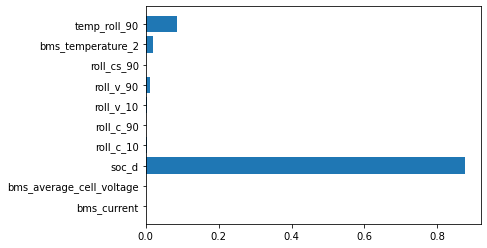

In [119]:
plt.barh(y= train_X.columns, width = feature_importance.tolist())

### XGBOOST

In [120]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(n_estimators = 250, max_depth = 10, eta=0.3, subsample = 0.7, colsample_bytree=0.8)

In [121]:
xgb_reg.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, ...)

In [123]:
# Predicting the results 

xgb_pred = xgb_reg.predict(test_X)
xgb_pred = xgb_pred.clip(0, 100)

In [124]:
xgb_rmse = np.sqrt(MSE(test_y, xgb_pred))
xgb_rmse

0.11812438476946502

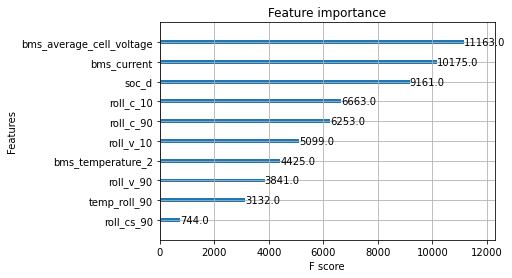

In [125]:
xgb.plot_importance(xgb_reg)
plt.show()

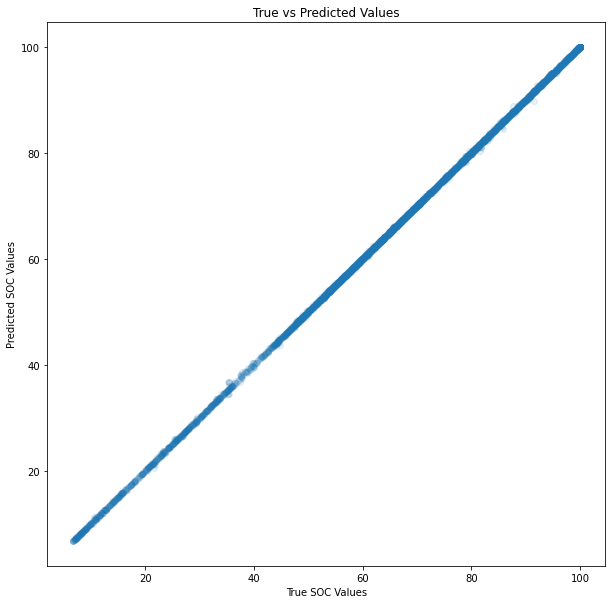

In [129]:
plt.figure(figsize=(10,10))
plt.scatter(test_y, xgb_pred, alpha=0.1)
plt.xlabel('True SOC Values')
plt.ylabel('Predicted SOC Values')
plt.title('True vs Predicted Values')
plt.show()

#### Error Analysis 

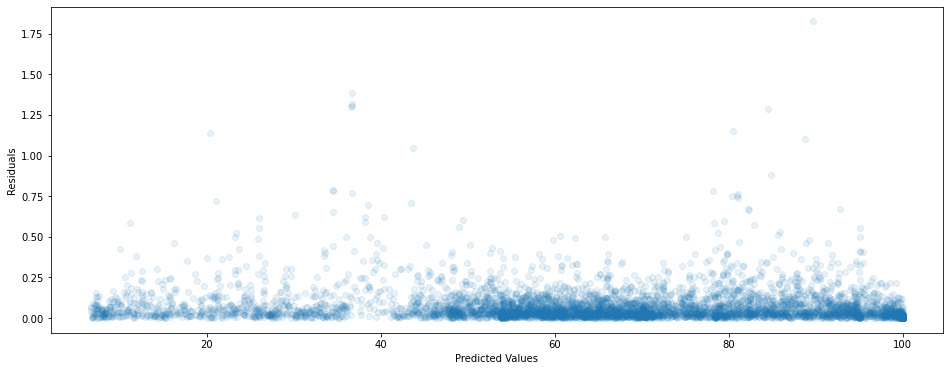

In [130]:
residual_abs = abs(test_y - xgb_pred)
plt.figure(figsize=(16, 6))
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.scatter(xgb_pred, residual_abs, alpha = 0.1)